# Evaluating Untrained DeiT-Ti for comparison with convDeit-Tiny

In [1]:
import timm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import Image, ImageFilter
from torchvision.transforms import ColorJitter
from torch.optim.lr_scheduler import CosineAnnealingLR
from itertools import product
import time
#Flops and efficiency logging
import time
from ptflops import get_model_complexity_info
# Seed setting
import random
import numpy as np
import torch
import os
import json

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_params(model):
    """Return number of trainable params."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Code for noise addition
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img).astype(np.float32) / 255.0
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)
        return Image.fromarray((noisy_img * 255).astype(np.uint8))

class RandomNoiseBlurOrJitter:
    def __init__(self, prob=0.2, noise_std=0.05, blur_radius=1, jitter_params=None):
        self.prob = prob
        self.noise_transform = AddGaussianNoise(std=noise_std)
        self.blur_radius = blur_radius
        self.jitter_transform = ColorJitter(**(jitter_params or {
            'brightness': 0.2,
            'contrast': 0.2,
            'saturation': 0.2,
            'hue': 0.1
        }))

    def __call__(self, img):
        if random.random() < self.prob:
            choice = random.choice(['noise', 'blur', 'jitter'])
            if choice == 'noise':
                img = self.noise_transform(img)
            elif choice == 'blur':
                img = img.filter(ImageFilter.GaussianBlur(radius=self.blur_radius))
            elif choice == 'jitter':
                img = self.jitter_transform(img)
        return img



#Data transformation and loading

# === Data transforms ===
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(270),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# === Load datasets ===
train_dataset = datasets.ImageFolder('Primary_Dataset/train', transform=transform_train)
val_dataset = datasets.ImageFolder('Primary_Dataset/val', transform=transform_val)
class_names = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# training
#commenting to do gridsearch
# Instantiate and move to device
model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=len(class_names)).to(device)
model.to(device)
macs, params = get_model_complexity_info(
    model,
    (3, 224, 224),  # input size
    as_strings=False,   # 👈 key: return float values
    print_per_layer_stat=False,
    verbose=False
)

# Convert MACs → FLOPs (1 MAC = 2 FLOPs)
flops = macs * 2  

print(f"MACs: {macs:,}")   # commas for readability
print(f"FLOPs: {flops:,}") # expanded number
print(f"Params: {params:,}")
print(f"Total Trainable Parameters in deit_tiny model is: {count_params(model):,}")

 # REMOVE TO STOP USING GRID SEARCH
# === Loss and optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = None


# === Training with Early Stopping ===
best_acc = 0
epochs = 200
patience = 20
patience_counter = 0
best_epoch = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if scheduler:
        scheduler.step()

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1:>3} — Loss: {avg_loss:.4f}, Val Accuracy: {acc*100:.2f}%")
    

    # === Check for improvement ===
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), 'Primary_best_scratch_deit_tiny.pth')
        #torch.save(model.state_dict(), 'complexity_deit_tiny.pth')
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Patience Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    
print(f"\n🎯 Best Accuracy: {best_acc*100:.2f}% at Epoch {best_epoch}")

/notebooks/mobileViTV2CDS/mobileViTV2CDS-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Seed set to 42 and logged in 'seed_log.json'.
MACs: 913,640,583
FLOPs: 1,827,281,166
Params: 5,524,995
Total Trainable Parameters in deit_tiny model is: 5,524,995


Epoch   1 — Loss: 0.8731, Val Accuracy: 66.24%
✅ New best model saved.


Epoch   2 — Loss: 0.7047, Val Accuracy: 61.08%
⏳ Patience Counter: 1/20


Epoch   3 — Loss: 0.6546, Val Accuracy: 78.49%
✅ New best model saved.


Epoch   4 — Loss: 0.5821, Val Accuracy: 81.94%
✅ New best model saved.


Epoch   5 — Loss: 0.4965, Val Accuracy: 82.37%
✅ New best model saved.


Epoch   6 — Loss: 0.4281, Val Accuracy: 82.37%
⏳ Patience Counter: 1/20


Epoch   7 — Loss: 0.3865, Val Accuracy: 87.53%
✅ New best model saved.


Epoch   8 — Loss: 0.3752, Val Accuracy: 89.03%
✅ New best model saved.


Epoch   9 — Loss: 0.3547, Val Accuracy: 88.17%
⏳ Patience Counter: 1/20


Epoch  10 — Loss: 0.3093, Val Accuracy: 91.18%
✅ New best model saved.


Epoch  11 — Loss: 0.3134, Val Accuracy: 89.03%
⏳ Patience Counter: 1/20


Epoch  12 — Loss: 0.3141, Val Accuracy: 88.82%
⏳ Patience Counter: 2/20


Epoch  13 — Loss: 0.3157, Val Accuracy: 91.61%
✅ New best model saved.


Epoch  14 — Loss: 0.2761, Val Accuracy: 90.32%
⏳ Patience Counter: 1/20


Epoch  15 — Loss: 0.2802, Val Accuracy: 90.97%
⏳ Patience Counter: 2/20


Epoch  16 — Loss: 0.2853, Val Accuracy: 92.90%
✅ New best model saved.


Epoch  17 — Loss: 0.2507, Val Accuracy: 90.11%
⏳ Patience Counter: 1/20


Epoch  18 — Loss: 0.2463, Val Accuracy: 92.26%
⏳ Patience Counter: 2/20


Epoch  19 — Loss: 0.2354, Val Accuracy: 93.76%
✅ New best model saved.


Epoch  20 — Loss: 0.2414, Val Accuracy: 91.40%
⏳ Patience Counter: 1/20


Epoch  21 — Loss: 0.2241, Val Accuracy: 89.46%
⏳ Patience Counter: 2/20


Epoch  22 — Loss: 0.2317, Val Accuracy: 94.62%
✅ New best model saved.


Epoch  23 — Loss: 0.2314, Val Accuracy: 91.83%
⏳ Patience Counter: 1/20


Epoch  24 — Loss: 0.2268, Val Accuracy: 92.90%
⏳ Patience Counter: 2/20


Epoch  25 — Loss: 0.2440, Val Accuracy: 93.55%
⏳ Patience Counter: 3/20


Epoch  26 — Loss: 0.2016, Val Accuracy: 94.41%
⏳ Patience Counter: 4/20


Epoch  27 — Loss: 0.1915, Val Accuracy: 94.84%
✅ New best model saved.


Epoch  28 — Loss: 0.1836, Val Accuracy: 93.33%
⏳ Patience Counter: 1/20


Epoch  29 — Loss: 0.1959, Val Accuracy: 93.55%
⏳ Patience Counter: 2/20


Epoch  30 — Loss: 0.2434, Val Accuracy: 94.62%
⏳ Patience Counter: 3/20


Epoch  31 — Loss: 0.1797, Val Accuracy: 93.55%
⏳ Patience Counter: 4/20


Epoch  32 — Loss: 0.1866, Val Accuracy: 95.05%
✅ New best model saved.


Epoch  33 — Loss: 0.1880, Val Accuracy: 92.26%
⏳ Patience Counter: 1/20


Epoch  34 — Loss: 0.2018, Val Accuracy: 92.04%
⏳ Patience Counter: 2/20


Epoch  35 — Loss: 0.1831, Val Accuracy: 93.98%
⏳ Patience Counter: 3/20


Epoch  36 — Loss: 0.1684, Val Accuracy: 92.69%
⏳ Patience Counter: 4/20


Epoch  37 — Loss: 0.1726, Val Accuracy: 95.27%
✅ New best model saved.


Epoch  38 — Loss: 0.1584, Val Accuracy: 94.41%
⏳ Patience Counter: 1/20


Epoch  39 — Loss: 0.1630, Val Accuracy: 93.76%
⏳ Patience Counter: 2/20


Epoch  40 — Loss: 0.1705, Val Accuracy: 93.76%
⏳ Patience Counter: 3/20


Epoch  41 — Loss: 0.1686, Val Accuracy: 94.19%
⏳ Patience Counter: 4/20


Epoch  42 — Loss: 0.1475, Val Accuracy: 91.61%
⏳ Patience Counter: 5/20


Epoch  43 — Loss: 0.1566, Val Accuracy: 94.84%
⏳ Patience Counter: 6/20


Epoch  44 — Loss: 0.1455, Val Accuracy: 93.33%
⏳ Patience Counter: 7/20


Epoch  45 — Loss: 0.1709, Val Accuracy: 92.69%
⏳ Patience Counter: 8/20


Epoch  46 — Loss: 0.1356, Val Accuracy: 93.76%
⏳ Patience Counter: 9/20


Epoch  47 — Loss: 0.1308, Val Accuracy: 94.19%
⏳ Patience Counter: 10/20


Epoch  48 — Loss: 0.1376, Val Accuracy: 93.76%
⏳ Patience Counter: 11/20


Epoch  49 — Loss: 0.1469, Val Accuracy: 93.12%
⏳ Patience Counter: 12/20


Epoch  50 — Loss: 0.1317, Val Accuracy: 94.41%
⏳ Patience Counter: 13/20


Epoch  51 — Loss: 0.1493, Val Accuracy: 95.05%
⏳ Patience Counter: 14/20


Epoch  52 — Loss: 0.1554, Val Accuracy: 94.84%
⏳ Patience Counter: 15/20


Epoch  53 — Loss: 0.1277, Val Accuracy: 95.27%
⏳ Patience Counter: 16/20


Epoch  54 — Loss: 0.1354, Val Accuracy: 96.34%
✅ New best model saved.


Epoch  55 — Loss: 0.1359, Val Accuracy: 94.41%
⏳ Patience Counter: 1/20


Epoch  56 — Loss: 0.1542, Val Accuracy: 94.41%
⏳ Patience Counter: 2/20


Epoch  57 — Loss: 0.1322, Val Accuracy: 94.84%
⏳ Patience Counter: 3/20


Epoch  58 — Loss: 0.1282, Val Accuracy: 94.41%
⏳ Patience Counter: 4/20


Epoch  59 — Loss: 0.1407, Val Accuracy: 95.70%
⏳ Patience Counter: 5/20


Epoch  60 — Loss: 0.1265, Val Accuracy: 95.70%
⏳ Patience Counter: 6/20


Epoch  61 — Loss: 0.1173, Val Accuracy: 96.34%
⏳ Patience Counter: 7/20


Epoch  62 — Loss: 0.1141, Val Accuracy: 95.27%
⏳ Patience Counter: 8/20


Epoch  63 — Loss: 0.1372, Val Accuracy: 96.34%
⏳ Patience Counter: 9/20


Epoch  64 — Loss: 0.1244, Val Accuracy: 96.34%
⏳ Patience Counter: 10/20


Epoch  65 — Loss: 0.1256, Val Accuracy: 96.56%
✅ New best model saved.


Epoch  66 — Loss: 0.1118, Val Accuracy: 96.77%
✅ New best model saved.


Epoch  67 — Loss: 0.1151, Val Accuracy: 95.91%
⏳ Patience Counter: 1/20


Epoch  68 — Loss: 0.1263, Val Accuracy: 95.91%
⏳ Patience Counter: 2/20


Epoch  69 — Loss: 0.1065, Val Accuracy: 93.76%
⏳ Patience Counter: 3/20


Epoch  70 — Loss: 0.1220, Val Accuracy: 94.84%
⏳ Patience Counter: 4/20


Epoch  71 — Loss: 0.1326, Val Accuracy: 95.05%
⏳ Patience Counter: 5/20


Epoch  72 — Loss: 0.0933, Val Accuracy: 96.56%
⏳ Patience Counter: 6/20


Epoch  73 — Loss: 0.1060, Val Accuracy: 95.48%
⏳ Patience Counter: 7/20


Epoch  74 — Loss: 0.0931, Val Accuracy: 96.77%
⏳ Patience Counter: 8/20


Epoch  75 — Loss: 0.1118, Val Accuracy: 95.70%
⏳ Patience Counter: 9/20


Epoch  76 — Loss: 0.0944, Val Accuracy: 94.84%
⏳ Patience Counter: 10/20


Epoch  77 — Loss: 0.0950, Val Accuracy: 96.99%
✅ New best model saved.


Epoch  78 — Loss: 0.0922, Val Accuracy: 95.05%
⏳ Patience Counter: 1/20


Epoch  79 — Loss: 0.1017, Val Accuracy: 95.05%
⏳ Patience Counter: 2/20


Epoch  80 — Loss: 0.1070, Val Accuracy: 96.34%
⏳ Patience Counter: 3/20


Epoch  81 — Loss: 0.0932, Val Accuracy: 95.91%
⏳ Patience Counter: 4/20


Epoch  82 — Loss: 0.1043, Val Accuracy: 94.84%
⏳ Patience Counter: 5/20


Epoch  83 — Loss: 0.0998, Val Accuracy: 96.13%
⏳ Patience Counter: 6/20


Epoch  84 — Loss: 0.1098, Val Accuracy: 96.13%
⏳ Patience Counter: 7/20


Epoch  85 — Loss: 0.0821, Val Accuracy: 97.20%
✅ New best model saved.


Epoch  86 — Loss: 0.1015, Val Accuracy: 94.62%
⏳ Patience Counter: 1/20


Epoch  87 — Loss: 0.0795, Val Accuracy: 96.56%
⏳ Patience Counter: 2/20


Epoch  88 — Loss: 0.0900, Val Accuracy: 97.20%
⏳ Patience Counter: 3/20


Epoch  89 — Loss: 0.0803, Val Accuracy: 95.05%
⏳ Patience Counter: 4/20


Epoch  90 — Loss: 0.0916, Val Accuracy: 96.56%
⏳ Patience Counter: 5/20


Epoch  91 — Loss: 0.0925, Val Accuracy: 96.34%
⏳ Patience Counter: 6/20


Epoch  92 — Loss: 0.0968, Val Accuracy: 94.84%
⏳ Patience Counter: 7/20


Epoch  93 — Loss: 0.0736, Val Accuracy: 96.99%
⏳ Patience Counter: 8/20


Epoch  94 — Loss: 0.0911, Val Accuracy: 95.05%
⏳ Patience Counter: 9/20


Epoch  95 — Loss: 0.0873, Val Accuracy: 96.34%
⏳ Patience Counter: 10/20


Epoch  96 — Loss: 0.0778, Val Accuracy: 97.85%
✅ New best model saved.


Epoch  97 — Loss: 0.1030, Val Accuracy: 97.63%
⏳ Patience Counter: 1/20


Epoch  98 — Loss: 0.0611, Val Accuracy: 95.48%
⏳ Patience Counter: 2/20


Epoch  99 — Loss: 0.0858, Val Accuracy: 96.13%
⏳ Patience Counter: 3/20


Epoch 100 — Loss: 0.0748, Val Accuracy: 95.48%
⏳ Patience Counter: 4/20


Epoch 101 — Loss: 0.0759, Val Accuracy: 93.76%
⏳ Patience Counter: 5/20


Epoch 102 — Loss: 0.1041, Val Accuracy: 95.70%
⏳ Patience Counter: 6/20


Epoch 103 — Loss: 0.0789, Val Accuracy: 95.91%
⏳ Patience Counter: 7/20


Epoch 104 — Loss: 0.0811, Val Accuracy: 96.34%
⏳ Patience Counter: 8/20


Epoch 105 — Loss: 0.0698, Val Accuracy: 95.27%
⏳ Patience Counter: 9/20


Epoch 106 — Loss: 0.0626, Val Accuracy: 96.13%
⏳ Patience Counter: 10/20


Epoch 107 — Loss: 0.1014, Val Accuracy: 96.34%
⏳ Patience Counter: 11/20


Epoch 108 — Loss: 0.0884, Val Accuracy: 95.05%
⏳ Patience Counter: 12/20


Epoch 109 — Loss: 0.0648, Val Accuracy: 97.42%
⏳ Patience Counter: 13/20


Epoch 110 — Loss: 0.0973, Val Accuracy: 96.34%
⏳ Patience Counter: 14/20


Epoch 111 — Loss: 0.0756, Val Accuracy: 96.77%
⏳ Patience Counter: 15/20


Epoch 112 — Loss: 0.0694, Val Accuracy: 97.20%
⏳ Patience Counter: 16/20


Epoch 113 — Loss: 0.0949, Val Accuracy: 96.13%
⏳ Patience Counter: 17/20


Epoch 114 — Loss: 0.0706, Val Accuracy: 94.41%
⏳ Patience Counter: 18/20


Epoch 115 — Loss: 0.0634, Val Accuracy: 96.77%
⏳ Patience Counter: 19/20


Epoch 116 — Loss: 0.0802, Val Accuracy: 95.91%
⏳ Patience Counter: 20/20
🛑 Early stopping triggered.

🎯 Best Accuracy: 97.85% at Epoch 96


[INFO] Seed set to 42 and logged in 'seed_log.json'.
✅ Test Accuracy: 93.1373%


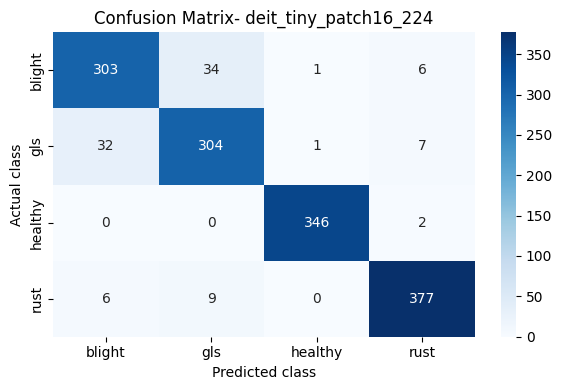

📄 Classification Report:

              precision    recall  f1-score   support

      blight     0.8886    0.8808    0.8847       344
         gls     0.8761    0.8837    0.8799       344
     healthy     0.9943    0.9943    0.9943       348
        rust     0.9617    0.9617    0.9617       392

    accuracy                         0.9314      1428
   macro avg     0.9302    0.9301    0.9301      1428
weighted avg     0.9314    0.9314    0.9314      1428



In [14]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import os
import numpy as np
# Seed setting
import random
import json

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)




# === Transform for test images (224x224) ===
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Load test dataset ===
test_dataset = datasets.ImageFolder('COMLDD_Dataset/test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Load trained model ===
model = timm.create_model(
    'deit_tiny_patch16_224',
    pretrained=False,
    num_classes=len(test_dataset.classes)
)
model.load_state_dict(torch.load('COMLDD_best_scratch_deit_tiny.pth', map_location=device))
model = model.to(device)
model.eval()

# === Evaluation ===
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Accuracy ===
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.4f}%")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix- deit_tiny_patch16_224')
plt.tight_layout()
plt.show()

# === Classification Report ===
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("📄 Classification Report:\n")
print(report)

# Evaluating Untrained DeiT-S for comparison on impact of parameters on accuracy

In [3]:
import timm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import Image, ImageFilter
from torchvision.transforms import ColorJitter
from torch.optim.lr_scheduler import CosineAnnealingLR
from itertools import product
import time
#Flops and efficiency logging
import time
from ptflops import get_model_complexity_info
# Seed setting
import random
import numpy as np
import torch
import os
import json

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_params(model):
    """Return number of trainable params."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Code for noise addition
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img).astype(np.float32) / 255.0
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)
        return Image.fromarray((noisy_img * 255).astype(np.uint8))

class RandomNoiseBlurOrJitter:
    def __init__(self, prob=0.2, noise_std=0.05, blur_radius=1, jitter_params=None):
        self.prob = prob
        self.noise_transform = AddGaussianNoise(std=noise_std)
        self.blur_radius = blur_radius
        self.jitter_transform = ColorJitter(**(jitter_params or {
            'brightness': 0.2,
            'contrast': 0.2,
            'saturation': 0.2,
            'hue': 0.1
        }))

    def __call__(self, img):
        if random.random() < self.prob:
            choice = random.choice(['noise', 'blur', 'jitter'])
            if choice == 'noise':
                img = self.noise_transform(img)
            elif choice == 'blur':
                img = img.filter(ImageFilter.GaussianBlur(radius=self.blur_radius))
            elif choice == 'jitter':
                img = self.jitter_transform(img)
        return img



#Data transformation and loading

# === Data transforms ===
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(270),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# === Load datasets ===
train_dataset = datasets.ImageFolder('Primary_Dataset/train', transform=transform_train)
val_dataset = datasets.ImageFolder('Primary_Dataset/val', transform=transform_val)
class_names = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# training
#commenting to do gridsearch
# Instantiate and move to device
model = timm.create_model('deit_small_patch16_224', pretrained=False, num_classes=len(class_names)).to(device)
model.to(device)
macs, params = get_model_complexity_info(
    model,
    (3, 224, 224),  # input size
    as_strings=False,   # 👈 key: return float values
    print_per_layer_stat=False,
    verbose=False
)

# Convert MACs → FLOPs (1 MAC = 2 FLOPs)
flops = macs * 2  

print(f"MACs: {macs:,}")   # commas for readability
print(f"FLOPs: {flops:,}") # expanded number
print(f"Params: {params:,}")
print(f"Total Trainable Parameters in deit_small model is: {count_params(model):,}")

 # REMOVE TO STOP USING GRID SEARCH
# === Loss and optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = None


# === Training with Early Stopping ===
best_acc = 0
epochs = 200
patience = 20
patience_counter = 0
best_epoch = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if scheduler:
        scheduler.step()

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1:>3} — Loss: {avg_loss:.4f}, Val Accuracy: {acc*100:.2f}%")
    

    # === Check for improvement ===
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), 'Primary_best_scratch_deit_small.pth')
        #torch.save(model.state_dict(), 'complexity_deit_small.pth')
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Patience Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    
print(f"\n🎯 Best Accuracy: {best_acc*100:.2f}% at Epoch {best_epoch}")

[INFO] Seed set to 42 and logged in 'seed_log.json'.
MACs: 3,221,625,099
FLOPs: 6,443,250,198
Params: 21,666,819
Total Trainable Parameters in deit_small model is: 21,666,819


Epoch   1 — Loss: 0.9407, Val Accuracy: 72.90%
✅ New best model saved.


Epoch   2 — Loss: 0.6985, Val Accuracy: 75.27%
✅ New best model saved.


Epoch   3 — Loss: 0.6187, Val Accuracy: 78.28%
✅ New best model saved.


Epoch   4 — Loss: 0.5432, Val Accuracy: 78.06%
⏳ Patience Counter: 1/20


Epoch   5 — Loss: 0.4690, Val Accuracy: 83.44%
✅ New best model saved.


Epoch   6 — Loss: 0.4271, Val Accuracy: 84.95%
✅ New best model saved.


Epoch   7 — Loss: 0.4257, Val Accuracy: 86.45%
✅ New best model saved.


Epoch   8 — Loss: 0.3956, Val Accuracy: 85.81%
⏳ Patience Counter: 1/20


Epoch   9 — Loss: 0.3416, Val Accuracy: 87.10%
✅ New best model saved.


Epoch  10 — Loss: 0.3075, Val Accuracy: 81.08%
⏳ Patience Counter: 1/20


Epoch  11 — Loss: 0.3484, Val Accuracy: 84.52%
⏳ Patience Counter: 2/20


Epoch  12 — Loss: 0.3183, Val Accuracy: 89.03%
✅ New best model saved.


Epoch  13 — Loss: 0.2991, Val Accuracy: 88.82%
⏳ Patience Counter: 1/20


Epoch  14 — Loss: 0.2709, Val Accuracy: 91.61%
✅ New best model saved.


Epoch  15 — Loss: 0.2645, Val Accuracy: 90.75%
⏳ Patience Counter: 1/20


Epoch  16 — Loss: 0.2659, Val Accuracy: 92.69%
✅ New best model saved.


Epoch  17 — Loss: 0.2473, Val Accuracy: 87.74%
⏳ Patience Counter: 1/20


Epoch  18 — Loss: 0.2551, Val Accuracy: 88.17%
⏳ Patience Counter: 2/20


Epoch  19 — Loss: 0.2309, Val Accuracy: 92.04%
⏳ Patience Counter: 3/20


Epoch  20 — Loss: 0.2477, Val Accuracy: 92.26%
⏳ Patience Counter: 4/20


Epoch  21 — Loss: 0.2293, Val Accuracy: 92.90%
✅ New best model saved.


Epoch  22 — Loss: 0.2356, Val Accuracy: 92.26%
⏳ Patience Counter: 1/20


Epoch  23 — Loss: 0.1989, Val Accuracy: 92.90%
⏳ Patience Counter: 2/20


Epoch  24 — Loss: 0.2117, Val Accuracy: 92.90%
⏳ Patience Counter: 3/20


Epoch  25 — Loss: 0.2060, Val Accuracy: 93.12%
✅ New best model saved.


Epoch  26 — Loss: 0.2089, Val Accuracy: 92.04%
⏳ Patience Counter: 1/20


Epoch  27 — Loss: 0.2241, Val Accuracy: 89.25%
⏳ Patience Counter: 2/20


Epoch  28 — Loss: 0.2002, Val Accuracy: 92.47%
⏳ Patience Counter: 3/20


Epoch  29 — Loss: 0.1896, Val Accuracy: 91.83%
⏳ Patience Counter: 4/20


Epoch  30 — Loss: 0.2174, Val Accuracy: 93.55%
✅ New best model saved.


Epoch  31 — Loss: 0.1897, Val Accuracy: 90.75%
⏳ Patience Counter: 1/20


Epoch  32 — Loss: 0.2003, Val Accuracy: 92.69%
⏳ Patience Counter: 2/20


Epoch  33 — Loss: 0.1779, Val Accuracy: 93.12%
⏳ Patience Counter: 3/20


Epoch  34 — Loss: 0.1748, Val Accuracy: 93.12%
⏳ Patience Counter: 4/20


Epoch  35 — Loss: 0.1853, Val Accuracy: 94.19%
✅ New best model saved.


Epoch  36 — Loss: 0.1766, Val Accuracy: 94.19%
⏳ Patience Counter: 1/20


Epoch  37 — Loss: 0.1834, Val Accuracy: 93.12%
⏳ Patience Counter: 2/20


Epoch  38 — Loss: 0.1834, Val Accuracy: 92.90%
⏳ Patience Counter: 3/20


Epoch  39 — Loss: 0.1683, Val Accuracy: 94.19%
⏳ Patience Counter: 4/20


Epoch  40 — Loss: 0.1669, Val Accuracy: 92.69%
⏳ Patience Counter: 5/20


Epoch  41 — Loss: 0.1449, Val Accuracy: 93.12%
⏳ Patience Counter: 6/20


Epoch  42 — Loss: 0.1491, Val Accuracy: 94.84%
✅ New best model saved.


Epoch  43 — Loss: 0.1467, Val Accuracy: 93.55%
⏳ Patience Counter: 1/20


Epoch  44 — Loss: 0.1635, Val Accuracy: 88.17%
⏳ Patience Counter: 2/20


Epoch  45 — Loss: 0.1440, Val Accuracy: 94.84%
⏳ Patience Counter: 3/20


Epoch  46 — Loss: 0.1451, Val Accuracy: 94.19%
⏳ Patience Counter: 4/20


Epoch  47 — Loss: 0.1452, Val Accuracy: 90.97%
⏳ Patience Counter: 5/20


Epoch  48 — Loss: 0.1352, Val Accuracy: 94.62%
⏳ Patience Counter: 6/20


Epoch  49 — Loss: 0.1588, Val Accuracy: 93.76%
⏳ Patience Counter: 7/20


Epoch  50 — Loss: 0.1440, Val Accuracy: 92.26%
⏳ Patience Counter: 8/20


Epoch  51 — Loss: 0.1473, Val Accuracy: 93.98%
⏳ Patience Counter: 9/20


Epoch  52 — Loss: 0.1396, Val Accuracy: 93.98%
⏳ Patience Counter: 10/20


Epoch  53 — Loss: 0.1410, Val Accuracy: 93.12%
⏳ Patience Counter: 11/20


Epoch  54 — Loss: 0.1329, Val Accuracy: 91.61%
⏳ Patience Counter: 12/20


Epoch  55 — Loss: 0.1447, Val Accuracy: 94.19%
⏳ Patience Counter: 13/20


Epoch  56 — Loss: 0.1172, Val Accuracy: 93.76%
⏳ Patience Counter: 14/20


Epoch  57 — Loss: 0.1262, Val Accuracy: 95.48%
✅ New best model saved.


Epoch  58 — Loss: 0.0994, Val Accuracy: 93.76%
⏳ Patience Counter: 1/20


Epoch  59 — Loss: 0.1250, Val Accuracy: 93.76%
⏳ Patience Counter: 2/20


Epoch  60 — Loss: 0.1294, Val Accuracy: 94.41%
⏳ Patience Counter: 3/20


Epoch  61 — Loss: 0.1043, Val Accuracy: 94.41%
⏳ Patience Counter: 4/20


Epoch  62 — Loss: 0.1043, Val Accuracy: 93.12%
⏳ Patience Counter: 5/20


Epoch  63 — Loss: 0.1249, Val Accuracy: 94.19%
⏳ Patience Counter: 6/20


Epoch  64 — Loss: 0.1185, Val Accuracy: 94.84%
⏳ Patience Counter: 7/20


Epoch  65 — Loss: 0.1263, Val Accuracy: 93.33%
⏳ Patience Counter: 8/20


Epoch  66 — Loss: 0.0942, Val Accuracy: 93.33%
⏳ Patience Counter: 9/20


Epoch  67 — Loss: 0.0994, Val Accuracy: 94.84%
⏳ Patience Counter: 10/20


Epoch  68 — Loss: 0.1083, Val Accuracy: 93.55%
⏳ Patience Counter: 11/20


Epoch  69 — Loss: 0.1033, Val Accuracy: 93.33%
⏳ Patience Counter: 12/20


Epoch  70 — Loss: 0.0993, Val Accuracy: 92.69%
⏳ Patience Counter: 13/20


Epoch  71 — Loss: 0.1156, Val Accuracy: 91.83%
⏳ Patience Counter: 14/20


Epoch  72 — Loss: 0.0946, Val Accuracy: 93.33%
⏳ Patience Counter: 15/20


Epoch  73 — Loss: 0.1035, Val Accuracy: 95.05%
⏳ Patience Counter: 16/20


Epoch  74 — Loss: 0.1358, Val Accuracy: 94.62%
⏳ Patience Counter: 17/20


Epoch  75 — Loss: 0.1109, Val Accuracy: 94.84%
⏳ Patience Counter: 18/20


Epoch  76 — Loss: 0.0819, Val Accuracy: 95.05%
⏳ Patience Counter: 19/20


Epoch  77 — Loss: 0.1045, Val Accuracy: 95.05%
⏳ Patience Counter: 20/20
🛑 Early stopping triggered.

🎯 Best Accuracy: 95.48% at Epoch 57


[INFO] Seed set to 42 and logged in 'seed_log.json'.
✅ Test Accuracy: 94.5378%


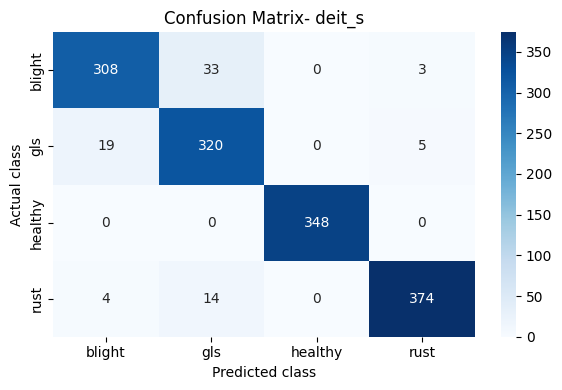

📄 Classification Report:

              precision    recall  f1-score   support

      blight     0.9305    0.8953    0.9126       344
         gls     0.8719    0.9302    0.9001       344
     healthy     1.0000    1.0000    1.0000       348
        rust     0.9791    0.9541    0.9664       392

    accuracy                         0.9454      1428
   macro avg     0.9454    0.9449    0.9448      1428
weighted avg     0.9467    0.9454    0.9457      1428



In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import os
import numpy as np

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)




# === Transform for test images (224x224) ===
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Load test dataset ===
test_dataset = datasets.ImageFolder('COMLDD_Dataset/test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Load trained model ===
model = timm.create_model(
    'deit_small_patch16_224',
    pretrained=False,
    num_classes=len(test_dataset.classes)
)
model.load_state_dict(torch.load('COMLDD_best_scratch_deit_small.pth', map_location=device))
model = model.to(device)
model.eval()

# === Evaluation ===
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Accuracy ===
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.4f}%")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix- deit_s')
plt.tight_layout()
plt.show()

# === Classification Report ===
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("📄 Classification Report:\n")
print(report)

# Evaluating Untrained DeiT-Ti-Distilled

In [5]:
import timm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import os
import random
import numpy as np
from PIL import Image, ImageFilter
from torchvision.transforms import ColorJitter
from torch.optim.lr_scheduler import CosineAnnealingLR
from itertools import product
import time
#Flops and efficiency logging
import time
from ptflops import get_model_complexity_info
# Seed setting
import random
import numpy as np
import torch
import os
import json

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def count_params(model):
    """Return number of trainable params."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Code for noise addition
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = np.array(img).astype(np.float32) / 255.0
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)
        return Image.fromarray((noisy_img * 255).astype(np.uint8))

class RandomNoiseBlurOrJitter:
    def __init__(self, prob=0.2, noise_std=0.05, blur_radius=1, jitter_params=None):
        self.prob = prob
        self.noise_transform = AddGaussianNoise(std=noise_std)
        self.blur_radius = blur_radius
        self.jitter_transform = ColorJitter(**(jitter_params or {
            'brightness': 0.2,
            'contrast': 0.2,
            'saturation': 0.2,
            'hue': 0.1
        }))

    def __call__(self, img):
        if random.random() < self.prob:
            choice = random.choice(['noise', 'blur', 'jitter'])
            if choice == 'noise':
                img = self.noise_transform(img)
            elif choice == 'blur':
                img = img.filter(ImageFilter.GaussianBlur(radius=self.blur_radius))
            elif choice == 'jitter':
                img = self.jitter_transform(img)
        return img



#Data transformation and loading

# === Data transforms ===
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(270),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    RandomNoiseBlurOrJitter(prob=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


# === Load datasets ===
train_dataset = datasets.ImageFolder('Primary_Dataset/train', transform=transform_train)
val_dataset = datasets.ImageFolder('Primary_Dataset/val', transform=transform_val)
class_names = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# training
#commenting to do gridsearch
# Instantiate and move to device
model = timm.create_model('deit_tiny_distilled_patch16_224', pretrained=False, num_classes=len(class_names)).to(device)

model.to(device)
macs, params = get_model_complexity_info(
    model,
    (3, 224, 224),  # input size
    as_strings=False,   # 👈 key: return float values
    print_per_layer_stat=False,
    verbose=False
)

# Convert MACs → FLOPs (1 MAC = 2 FLOPs)
flops = macs * 2  

print(f"MACs: {macs:,}")   # commas for readability
print(f"FLOPs: {flops:,}") # expanded number
print(f"Params: {params:,}")
print(f"Total Trainable Parameters in deit_tiny_distilled model is: {count_params(model):,}")
 # REMOVE TO STOP USING GRID SEARCH
# === Loss and optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = None


# === Training with Early Stopping ===
best_acc = 0
epochs = 200
patience = 20
patience_counter = 0
best_epoch = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if scheduler:
        scheduler.step()

    # === Validation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1:>3} — Loss: {avg_loss:.4f}, Val Accuracy: {acc*100:.2f}%")
    

    # === Check for improvement ===
    if acc > best_acc:
        best_acc = acc
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save(model.state_dict(), 'Primary_best_scratch_deit_tiny_distilled.pth')
        #torch.save(model.state_dict(), 'complexity_deit_tiny_distilled.pth')

        print("✅ New best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Patience Counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    
print(f"\n🎯 Best Accuracy: {best_acc*100:.2f}% at Epoch {best_epoch}")

[INFO] Seed set to 42 and logged in 'seed_log.json'.
MACs: 919,051,542
FLOPs: 1,838,103,084
Params: 5,525,958
Total Trainable Parameters in deit_tiny_distilled model is: 5,525,958


Epoch   1 — Loss: 0.8525, Val Accuracy: 63.23%
✅ New best model saved.


Epoch   2 — Loss: 0.7179, Val Accuracy: 74.41%
✅ New best model saved.


Epoch   3 — Loss: 0.6820, Val Accuracy: 78.49%
✅ New best model saved.


Epoch   4 — Loss: 0.6090, Val Accuracy: 78.71%
✅ New best model saved.


Epoch   5 — Loss: 0.5073, Val Accuracy: 80.65%
✅ New best model saved.


Epoch   6 — Loss: 0.4789, Val Accuracy: 82.58%
✅ New best model saved.


Epoch   7 — Loss: 0.4423, Val Accuracy: 81.72%
⏳ Patience Counter: 1/20


Epoch   8 — Loss: 0.3926, Val Accuracy: 88.17%
✅ New best model saved.


Epoch   9 — Loss: 0.3916, Val Accuracy: 85.38%
⏳ Patience Counter: 1/20


Epoch  10 — Loss: 0.3512, Val Accuracy: 86.67%
⏳ Patience Counter: 2/20


Epoch  11 — Loss: 0.3733, Val Accuracy: 82.58%
⏳ Patience Counter: 3/20


Epoch  12 — Loss: 0.3316, Val Accuracy: 87.53%
⏳ Patience Counter: 4/20


Epoch  13 — Loss: 0.3389, Val Accuracy: 87.96%
⏳ Patience Counter: 5/20


Epoch  14 — Loss: 0.3069, Val Accuracy: 86.67%
⏳ Patience Counter: 6/20


Epoch  15 — Loss: 0.3044, Val Accuracy: 88.82%
✅ New best model saved.


Epoch  16 — Loss: 0.2824, Val Accuracy: 88.39%
⏳ Patience Counter: 1/20


Epoch  17 — Loss: 0.3269, Val Accuracy: 88.17%
⏳ Patience Counter: 2/20


Epoch  18 — Loss: 0.2729, Val Accuracy: 91.83%
✅ New best model saved.


Epoch  19 — Loss: 0.2528, Val Accuracy: 91.61%
⏳ Patience Counter: 1/20


Epoch  20 — Loss: 0.2573, Val Accuracy: 90.54%
⏳ Patience Counter: 2/20


Epoch  21 — Loss: 0.2535, Val Accuracy: 87.74%
⏳ Patience Counter: 3/20


Epoch  22 — Loss: 0.2524, Val Accuracy: 90.11%
⏳ Patience Counter: 4/20


Epoch  23 — Loss: 0.2549, Val Accuracy: 89.89%
⏳ Patience Counter: 5/20


Epoch  24 — Loss: 0.2353, Val Accuracy: 89.25%
⏳ Patience Counter: 6/20


Epoch  25 — Loss: 0.2251, Val Accuracy: 90.75%
⏳ Patience Counter: 7/20


Epoch  26 — Loss: 0.2397, Val Accuracy: 90.54%
⏳ Patience Counter: 8/20


Epoch  27 — Loss: 0.2273, Val Accuracy: 91.40%
⏳ Patience Counter: 9/20


Epoch  28 — Loss: 0.2136, Val Accuracy: 92.90%
✅ New best model saved.


Epoch  29 — Loss: 0.2320, Val Accuracy: 94.19%
✅ New best model saved.


Epoch  30 — Loss: 0.1895, Val Accuracy: 92.69%
⏳ Patience Counter: 1/20


Epoch  31 — Loss: 0.2069, Val Accuracy: 92.90%
⏳ Patience Counter: 2/20


Epoch  32 — Loss: 0.2103, Val Accuracy: 90.11%
⏳ Patience Counter: 3/20


Epoch  33 — Loss: 0.2040, Val Accuracy: 92.90%
⏳ Patience Counter: 4/20


Epoch  34 — Loss: 0.2086, Val Accuracy: 92.26%
⏳ Patience Counter: 5/20


Epoch  35 — Loss: 0.2126, Val Accuracy: 90.11%
⏳ Patience Counter: 6/20


Epoch  36 — Loss: 0.2114, Val Accuracy: 89.89%
⏳ Patience Counter: 7/20


Epoch  37 — Loss: 0.1845, Val Accuracy: 93.12%
⏳ Patience Counter: 8/20


Epoch  38 — Loss: 0.1669, Val Accuracy: 90.75%
⏳ Patience Counter: 9/20


Epoch  39 — Loss: 0.1750, Val Accuracy: 95.48%
✅ New best model saved.


Epoch  40 — Loss: 0.1859, Val Accuracy: 95.05%
⏳ Patience Counter: 1/20


Epoch  41 — Loss: 0.1764, Val Accuracy: 94.84%
⏳ Patience Counter: 2/20


Epoch  42 — Loss: 0.1851, Val Accuracy: 94.62%
⏳ Patience Counter: 3/20


Epoch  43 — Loss: 0.1548, Val Accuracy: 89.68%
⏳ Patience Counter: 4/20


Epoch  44 — Loss: 0.1955, Val Accuracy: 91.18%
⏳ Patience Counter: 5/20


Epoch  45 — Loss: 0.1534, Val Accuracy: 92.69%
⏳ Patience Counter: 6/20


Epoch  46 — Loss: 0.1607, Val Accuracy: 91.40%
⏳ Patience Counter: 7/20


Epoch  47 — Loss: 0.1630, Val Accuracy: 93.55%
⏳ Patience Counter: 8/20


Epoch  48 — Loss: 0.1734, Val Accuracy: 92.90%
⏳ Patience Counter: 9/20


Epoch  49 — Loss: 0.1809, Val Accuracy: 94.19%
⏳ Patience Counter: 10/20


Epoch  50 — Loss: 0.1843, Val Accuracy: 92.90%
⏳ Patience Counter: 11/20


Epoch  51 — Loss: 0.1497, Val Accuracy: 93.33%
⏳ Patience Counter: 12/20


Epoch  52 — Loss: 0.1736, Val Accuracy: 94.62%
⏳ Patience Counter: 13/20


Epoch  53 — Loss: 0.1467, Val Accuracy: 92.69%
⏳ Patience Counter: 14/20


Epoch  54 — Loss: 0.1387, Val Accuracy: 92.90%
⏳ Patience Counter: 15/20


Epoch  55 — Loss: 0.1609, Val Accuracy: 94.19%
⏳ Patience Counter: 16/20


Epoch  56 — Loss: 0.1522, Val Accuracy: 95.91%
✅ New best model saved.


Epoch  57 — Loss: 0.1439, Val Accuracy: 94.41%
⏳ Patience Counter: 1/20


Epoch  58 — Loss: 0.1763, Val Accuracy: 93.98%
⏳ Patience Counter: 2/20


Epoch  59 — Loss: 0.1402, Val Accuracy: 92.69%
⏳ Patience Counter: 3/20


Epoch  60 — Loss: 0.1287, Val Accuracy: 94.41%
⏳ Patience Counter: 4/20


Epoch  61 — Loss: 0.1335, Val Accuracy: 93.98%
⏳ Patience Counter: 5/20


Epoch  62 — Loss: 0.1366, Val Accuracy: 92.47%
⏳ Patience Counter: 6/20


Epoch  63 — Loss: 0.1437, Val Accuracy: 94.62%
⏳ Patience Counter: 7/20


Epoch  64 — Loss: 0.1513, Val Accuracy: 92.69%
⏳ Patience Counter: 8/20


Epoch  65 — Loss: 0.1406, Val Accuracy: 95.27%
⏳ Patience Counter: 9/20


Epoch  66 — Loss: 0.1244, Val Accuracy: 92.90%
⏳ Patience Counter: 10/20


Epoch  67 — Loss: 0.1218, Val Accuracy: 93.12%
⏳ Patience Counter: 11/20


Epoch  68 — Loss: 0.1340, Val Accuracy: 94.84%
⏳ Patience Counter: 12/20


Epoch  69 — Loss: 0.1305, Val Accuracy: 95.05%
⏳ Patience Counter: 13/20


Epoch  70 — Loss: 0.1246, Val Accuracy: 94.84%
⏳ Patience Counter: 14/20


Epoch  71 — Loss: 0.1111, Val Accuracy: 93.76%
⏳ Patience Counter: 15/20


Epoch  72 — Loss: 0.1229, Val Accuracy: 97.20%
✅ New best model saved.


Epoch  73 — Loss: 0.1176, Val Accuracy: 93.12%
⏳ Patience Counter: 1/20


Epoch  74 — Loss: 0.1285, Val Accuracy: 95.70%
⏳ Patience Counter: 2/20


Epoch  75 — Loss: 0.1294, Val Accuracy: 96.34%
⏳ Patience Counter: 3/20


Epoch  76 — Loss: 0.1158, Val Accuracy: 94.41%
⏳ Patience Counter: 4/20


Epoch  77 — Loss: 0.1166, Val Accuracy: 95.05%
⏳ Patience Counter: 5/20


Epoch  78 — Loss: 0.1499, Val Accuracy: 95.05%
⏳ Patience Counter: 6/20


Epoch  79 — Loss: 0.1258, Val Accuracy: 94.41%
⏳ Patience Counter: 7/20


Epoch  80 — Loss: 0.1276, Val Accuracy: 94.41%
⏳ Patience Counter: 8/20


Epoch  81 — Loss: 0.1229, Val Accuracy: 94.19%
⏳ Patience Counter: 9/20


Epoch  82 — Loss: 0.1241, Val Accuracy: 94.41%
⏳ Patience Counter: 10/20


Epoch  83 — Loss: 0.1157, Val Accuracy: 95.48%
⏳ Patience Counter: 11/20


Epoch  84 — Loss: 0.1179, Val Accuracy: 93.55%
⏳ Patience Counter: 12/20


Epoch  85 — Loss: 0.1103, Val Accuracy: 93.55%
⏳ Patience Counter: 13/20


Epoch  86 — Loss: 0.0989, Val Accuracy: 95.48%
⏳ Patience Counter: 14/20


Epoch  87 — Loss: 0.1032, Val Accuracy: 94.62%
⏳ Patience Counter: 15/20


Epoch  88 — Loss: 0.1103, Val Accuracy: 92.47%
⏳ Patience Counter: 16/20


Epoch  89 — Loss: 0.1240, Val Accuracy: 94.41%
⏳ Patience Counter: 17/20


Epoch  90 — Loss: 0.1169, Val Accuracy: 93.98%
⏳ Patience Counter: 18/20


Epoch  91 — Loss: 0.1145, Val Accuracy: 94.19%
⏳ Patience Counter: 19/20


Epoch  92 — Loss: 0.1039, Val Accuracy: 94.84%
⏳ Patience Counter: 20/20
🛑 Early stopping triggered.

🎯 Best Accuracy: 97.20% at Epoch 72


[INFO] Seed set to 42 and logged in 'seed_log.json'.
✅ Test Accuracy: 92.5070%


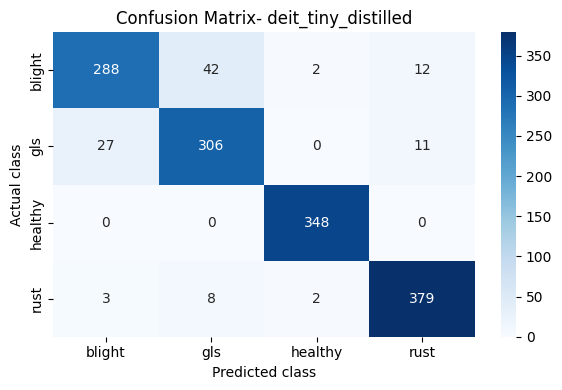

📄 Classification Report:

              precision    recall  f1-score   support

      blight     0.9057    0.8372    0.8701       344
         gls     0.8596    0.8895    0.8743       344
     healthy     0.9886    1.0000    0.9943       348
        rust     0.9428    0.9668    0.9547       392

    accuracy                         0.9251      1428
   macro avg     0.9242    0.9234    0.9233      1428
weighted avg     0.9250    0.9251    0.9246      1428



In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import timm
import os
import numpy as np
# Seed setting
import random
import json
# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reproducibility ===
def set_seed(seed: int = 42, save_path: str = "seed_log.json"):
    """
    Set the random seed for Python, NumPy, and PyTorch.
    Saves the seed to a file so it can be reused later.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Save seed info
    seed_data = {
        "seed": seed
    }

    with open(save_path, "w") as f:
        json.dump(seed_data, f)

    print(f"[INFO] Seed set to {seed} and logged in '{save_path}'.")
set_seed (42)




# === Transform for test images (224x224) ===
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === Load test dataset ===
test_dataset = datasets.ImageFolder('COMLDD_Dataset/test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Load trained model ===
model = timm.create_model(
    'deit_tiny_distilled_patch16_224',
    pretrained=False,
    num_classes=len(test_dataset.classes)
)
model.load_state_dict(torch.load('COMLDD_best_scratch_deit_tiny_distilled.pth', map_location=device))
model = model.to(device)
model.eval()

# === Evaluation ===
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Accuracy ===
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.4f}%")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.title('Confusion Matrix- deit_tiny_distilled')
plt.tight_layout()
plt.show()

# === Classification Report ===
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("📄 Classification Report:\n")
print(report)